In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed = 855835128

In [2]:
# file = pd.read_csv(r'E:\Auckland\2022 Semester 2\COMPSCI 760\Assignment\Presentation 2\ModelDf.csv',sep=',',usecols=[3,4,5,8])
file = pd.read_csv('AgeDataset-V1.csv' )
#file = file.dropna()

In [3]:
file.dropna(subset=['Manner of death'], inplace=True) #deleting the null row of manner of death
file.dropna(subset=['Occupation'], inplace=True)
file.dropna(subset=['Gender'], inplace=True)
file.dropna(subset=['Country'], inplace=True)
file.dropna(subset=['Birth year'], inplace=True)

## Gender

In [4]:
file['Gender'].value_counts()

Male                          38510
Female                         7317
Transgender Female               19
Transgender Male                 11
Eunuch; Male                      4
Intersex                          2
Transgender Female; Female        1
Eunuch                            1
Name: Gender, dtype: int64

In [5]:
gender_combine = {'Transgender Female' : 'Diverse', 
                  'Transgender Male': 'Diverse', 
                  'Eunuch; Male' : 'Diverse', 
                  'Transgender Female; Female':'Diverse',
                  'Eunuch':'Diverse', 
                  'Intersex': 'Diverse', 
                 }
file['Gender'] = file['Gender'].replace(gender_combine)
file['Gender'].value_counts()

Male       38510
Female      7317
Diverse       38
Name: Gender, dtype: int64

## Manner of death

In [6]:
file['Manner of death'].value_counts()

natural causes                              31056
suicide                                      4515
accident                                     4377
homicide                                     3282
capital punishment                           1775
                                            ...  
suicide; substance dependence                   1
deliberate murder                               1
suicide; suicide by poisoning with drugs        1
accident; bull                                  1
White Terror                                    1
Name: Manner of death, Length: 177, dtype: int64

(-0.5, 799.5, 499.5, -0.5)

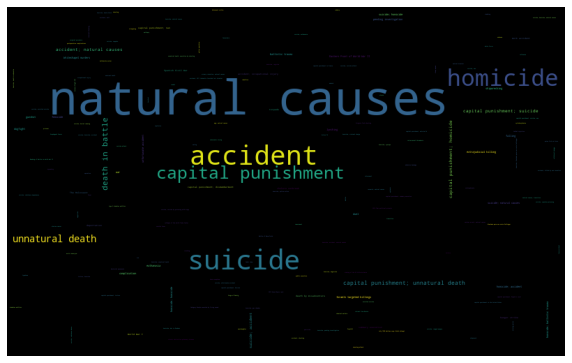

In [7]:
from wordcloud import WordCloud 

MoD = file['Manner of death'].value_counts().to_dict()
freq_death = WordCloud(width =800, height =500, min_font_size=2).generate_from_frequencies(MoD)
plt.figure(figsize=(10,10))
plt.imshow(freq_death)
plt.axis('off')

Making natural causes, accident, suicide, homicide and capital punishment our target label.

In [8]:
file['Manner of death']=file['Manner of death'].astype(str)
file['Manner of death']=file['Manner of death'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Manner of death'].value_counts()

natural causes        31057
suicide                4567
accident               4412
homicide               3314
capital punishment     1905
                      ...  
strangling                1
influenza                 1
underwater diving         1
deliberate murder         1
White Terror              1
Name: Manner of death, Length: 123, dtype: int64

Feature engineering

In [9]:
#only getting the top 5 deaths
deaths = ['natural causes' ,'suicide', 'homicide', 'accident', 'capital punishment']
file = file[file['Manner of death'].isin(deaths)]

<AxesSubplot:title={'center':'Percentage of manner of deaths'}, ylabel='Count'>

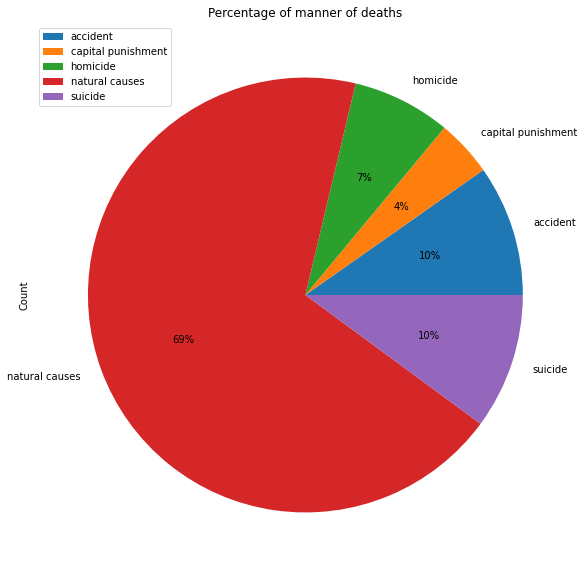

In [10]:
#pie chart for manner of death
#class imbalance
Manner_of_death = file[['Manner of death']].groupby(['Manner of death']).size().reset_index(name='Count').sort_values('Count', ascending = False)
Manner_of_death.groupby(['Manner of death']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%',title='Percentage of manner of deaths', figsize=(15, 10))

<AxesSubplot:xlabel='Age of death', ylabel='Manner of death'>

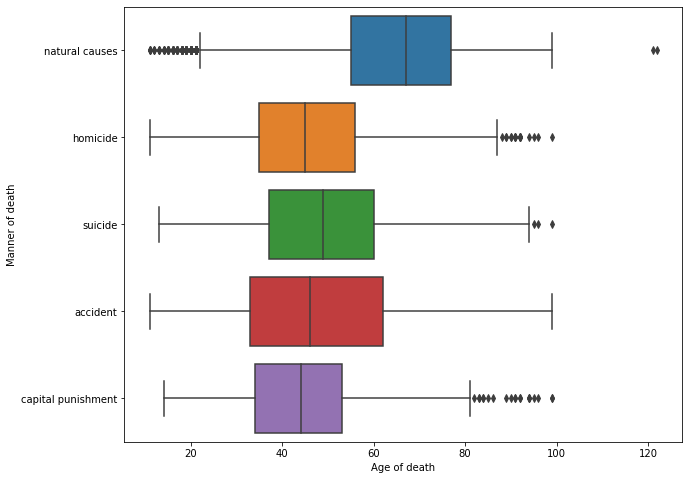

In [11]:
plt.figure(figsize=(10,8))
sns.boxplot(data=file, x='Age of death', y = 'Manner of death')

## Occupation

In [12]:
file['Occupation']=file['Occupation'].astype(str)
file['Occupation']=file['Occupation'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
occu = file['Occupation'].value_counts()
top_occupation = occu.head(10)
top_occupation

Artist                17928
Politician             7168
Athlete                5623
Researcher             2678
Military personnel     1990
Journalist              920
Businessperson          748
Religious figure        676
Teacher                 395
Engineer                308
Name: Occupation, dtype: int64

## Country

In [13]:
file['Country']=file['Country'].astype(str)
file['Country']=file['Country'].apply(lambda x:x.split(';')[0]) # only getting the first word before the ;
file['Country'].value_counts()

United States of America    17554
United Kingdom               3355
France                       2635
Germany                      1826
Canada                       1401
                            ...  
Duchy of Lorraine               1
Low Countries                   1
Kyrgyzstan                      1
Americana                       1
County of Holland               1
Name: Country, Length: 457, dtype: int64

In [14]:
# pd.crosstab(file['Manner of death'],file['Occupation'],normalize='index').plot.bar(stacked=True)

<AxesSubplot:xlabel='Manner of death'>

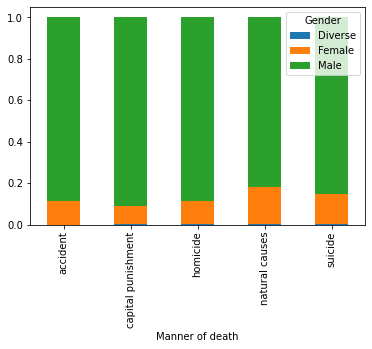

In [15]:
pd.crosstab(file['Manner of death'],file['Gender'],normalize='index').plot.bar(stacked=True)

In [16]:
file.reset_index(drop=True, inplace=True)

## Hyper parameter tuning

In [17]:
file

,Id,Name,Short description,Gender,Country,Occupation,Birth year,Death year,Manner of death,Age of death
0,Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America,Politician,1732,1799.0,natural causes,67.0
1,Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001.0,natural causes,49.0
2,Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865.0,homicide,56.0
3,Q260,Jean-François Champollion,French classical scholar,Male,Kingdom of France,Egyptologist,1790,1832.0,natural causes,42.0
4,Q296,Claude Monet,French impressionist painter (1840-1926),Male,France,Artist,1840,1926.0,natural causes,86.0
...,...,...,...,...,...,...,...,...,...,...
45250,Q75336010,George Dewey Sanford Jr.,United States Marine,Male,United States of America,Military personnel,1925,1994.0,suicide,69.0
45251,Q75349931,John Saxton,British diarist and settler in New Zealand,Male,United Kingdom of Great Britain and Ireland,Settler,1807,1866.0,suicide,59.0
45252,Q75717629,Antonín Gruncl,Czechoslovak musician,Male,Czechoslovakia,Artist,1905,1942.0,capital punishment,37.0
45253,Q76161186,Sara Champion,British archaeologist,Female,United Kingdom,Researcher,1946,2000.0,natural causes,54.0


In [18]:
target = file['Manner of death'] #decreased the labels to 5 
data = file[['Gender','Occupation','Country','Birth year']]

In [19]:
target.nunique()

5

In [20]:
data.isnull().sum()

Gender        0
Occupation    0
Country       0
Birth year    0
dtype: int64

In [24]:
# pre-processing data
data_T = data.T
arr1 = data_T.to_numpy()
temp = np.zeros((4,len(data)))
le1 = preprocessing.LabelEncoder()
for i in range(len(arr1)):
    le1.fit(arr1[i])
    temp[i] = le1.transform(arr1[i])
x_T = pd.DataFrame(temp)
x = x_T.T
x = x.to_numpy()

arr2 = target.to_numpy()
le2 = preprocessing.LabelEncoder()
le2.fit(arr2)
y = le2.transform(arr2)
# The result of pre-processing
print("The feature vectors:\n",x)
print("The predictive vector:\n",y)

The feature vectors:
 [[  2. 582. 430. 707.]
 [  2.  46. 428. 927.]
 [  2. 582. 430. 784.]
 ...
 [  2.  46.  85. 880.]
 [  1. 647. 428. 921.]
 [  2. 471. 430. 814.]]
The predictive vector:
 [3 3 2 ... 1 3 2]


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = seed)

In [26]:
# calculate Gini and Enrtopy
DT = DecisionTreeClassifier(random_state = seed)
score = cross_val_score(DT,x,y,cv=5).mean()
print('Gini: %.4f'%score)
DT = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
score = cross_val_score(DT,x,y,cv=5).mean()
print('Entropy: %.4f'%score)

Gini: 0.6048
Entropy: 0.6051


Entropy is better than Gini in this data set.

The optimal parameters and the highest score:
 [1.         0.68626671]


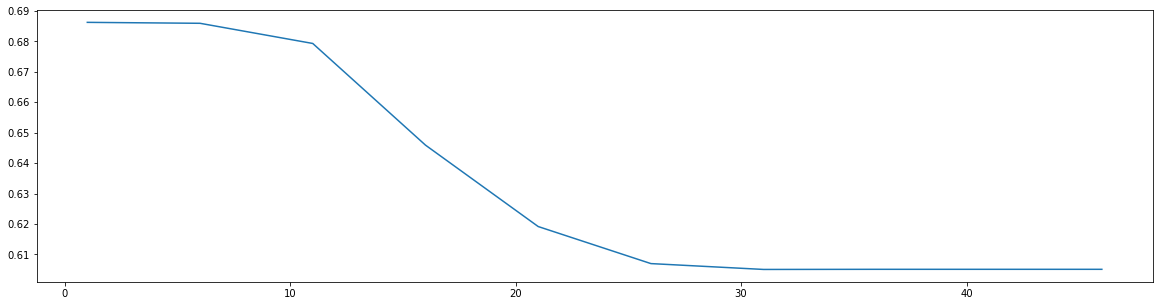

In [27]:
ScoreAll = []
for i in range(1,50,5):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv = 5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

The optimal parameters and the highest score:
 [3.       0.686333]


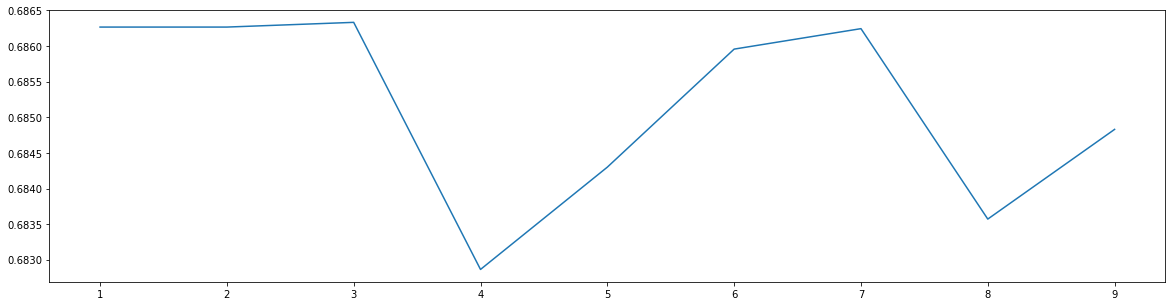

In [28]:
ScoreAll = []
for i in range(1,10):
    DT = DecisionTreeClassifier(max_depth = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv = 5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

The optimal parameters and the highest score:
 [2.       0.686333]


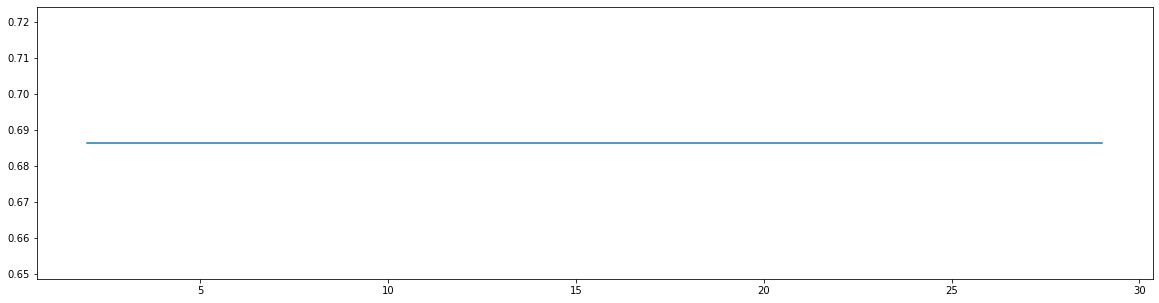

In [30]:
# consider min_samples_split
ScoreAll = []
for i in range(2,30):
    DT = DecisionTreeClassifier(max_depth = 3, min_samples_split = i,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

There is no need to modify the min_samples_split parameter.

The optimal parameters and the highest score:
 [1.       0.686333]


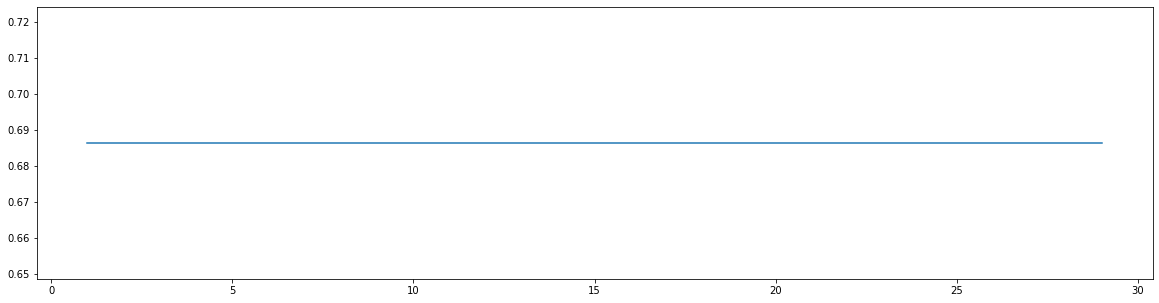

In [31]:
# consider min_samples_leaf
ScoreAll = []
for i in range(1,30):
    DT = DecisionTreeClassifier(min_samples_leaf = i, min_samples_split = 2,max_depth = 3,criterion = 'entropy',random_state = seed)
    score = cross_val_score(DT,x,y,cv=5).mean()
    ScoreAll.append([i,score])
ScoreAll = np.array(ScoreAll)

max_score = np.where(ScoreAll == np.max(ScoreAll[:,1]))[0][0]
print("The optimal parameters and the highest score:\n",ScoreAll[max_score])
plt.figure(figsize = [20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

In [32]:
# Entropy,max_depth = 3, min_samples_leaf = 1, min_samples_split = 2
param_grid = {
    'max_depth':np.arange(1,10),
    'min_samples_leaf':np.arange(1,10),
    'min_samples_split':np.arange(2,10)
}
DTC = DecisionTreeClassifier(criterion = 'entropy',random_state = seed)
GS = GridSearchCV(DTC,param_grid,cv=5)
GS.fit(x,y)
print(GS.best_params_)
print(GS.best_score_)

{'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 2}
0.6866865539719369


In [33]:
DT = DecisionTreeClassifier(max_depth= 7, min_samples_leaf= 7, min_samples_split= 2)

DTClass = DT.fit(x_train,y_train)

train_score = DTClass.score(x_train, y_train)
print('Accuracy on train set: {:.3f}%'.format(train_score * 100))

test_score = DTClass.score(x_test, y_test)
print('Accuracy on test set: {:.3f}%'.format(test_score * 100))

Accuracy on train set: 69.577%
Accuracy on test set: 70.106%
